In [3]:
from matplotlib import pyplot as plt
import numpy as np
import functions as func
import models as mod
import torch
from tqdm import tqdm
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
from sklearn import preprocessing
from sklearn.preprocessing import normalize
import seaborn as sns
import data_functions as df
import functions as f
from scipy.stats import ortho_group
import random
from torch import linalg as tLA

In [4]:
def generate_subspace_data(V, n, d, r, num_corrupted, gamma):
    """
    Inputs:
        - d is the dimension of the data
        - n is the number of data points
        - V is a dxd orthonormal matrix which stores basis vectors
        - r is the dimension of the signal subspace, i.e., columns of V[:,r] form basis
        of signal subspace
        - num_corrupted is the number of corruptions, for convenience ensure is even
        - gamma should be in (0,1) and is the fraction of signal norm vs data norm (which is 1).
        For example, gamma = 0.5 means noise and signal have equal power or norm.
        
    Outputs:
        - X is an nxd tensor where each row is a data point which has unit norm
        - y is an nx1 tensor detailing labels of each data point, first and last k = num_corrupted/2 entries
        flipped / corrupted
        - S is an nxd tensor where each row holds signal component of an input
        - N is an nxd tensor where each row holds noise component of an input
    """
    n2 = int(np.floor(n / 2))
    y = torch.cat((-torch.ones(n2), torch.ones(n2)), 0)
    # Generate latent for signal component and normalize
    Zs = torch.rand(r,n)
    Zs = Zs/tLA.norm(Zs, dim = 0) 
    Zs = Zs@(torch.diag(y))
    # Generate latent for noise component, normalize then multiply by ns
    Zn = torch.randn(d-r,n)
    Zn = Zn / tLA.norm(Zn, dim = 0)
    # Compute data inputs from signal and noise components
    S = V[:,:r]@Zs
    N = V[:,r:]@Zn
    X = np.sqrt(gamma)*S+np.sqrt(1-gamma)*N
    # Add corruptions to labels
    k = int(num_corrupted/2)
    y[:k] *= -1
    y[-k:] *= -1
    # Transpose inputs and labels so that ready for processing
    X = torch.transpose(X,0,1)
    N = torch.transpose(N, 0, 1)
    S = torch.transpose(S, 0, 1)
    y = torch.reshape(y,(n,1))
    clean_inds = [i for i in range(k,n-k)]
    corr_inds = [i for i in range(k)] + [i for i in range(n-k,n)] 
    return X,y,S,N,clean_inds,corr_inds

In [5]:
class hinge_loss(nn.Module):
    """
    Class for hinge loss
    """
    def __init__(self, a):
        super(hinge_loss, self).__init__()
        self.a = a
        self.relu = nn.ReLU()

    def forward(self, predictions, target):
        return torch.mean(self.relu(self.a - predictions*target))

In [6]:
def train_simple(model, optimizer, loss_fn, train_x, train_y, num_epochs, train_size, batch_size):
    for epoch in tqdm(range(num_epochs+1)):
        optimizer.zero_grad()
        inds = random.sample(range(train_size), batch_size)
        batch_x = train_x[inds,:]
        batch_y = train_y[inds]
        batch_output = model(batch_x)
        loss = loss_fn(batch_output, batch_y)
        loss.backward()
        optimizer.step()
    return model

In [16]:
def train_detailed(model ,m, optimizer, loss_fn, train_x, train_y, train_n, train_s, test_x, test_y, num_epochs, train_size, test_size, batch_size, corr_inds, clean_inds):
    """
    
    """
    # Initialize Numpy arrays holding train and test loss and error by epoch
    train_loss = -100*np.ones(num_epochs+1)
    train_loss_clean = -100*np.ones(num_epochs+1)
    train_loss_corr = -100*np.ones(num_epochs+1)
    
    train_error = -100*np.ones(num_epochs+1)
    train_error_clean = -100*np.ones(num_epochs+1)
    train_error_corr = -100*np.ones(num_epochs+1)
    
    test_loss = -100*np.ones(num_epochs+1)
    test_error = -100*np.ones(num_epochs+1)
    
    # !!!!! Compute train and test loss and error (also breakdown by clean and corrupted) !!!!!
    train_loss[0] = loss_fn(train_x, train_y)
    train_loss_clean[0] = loss_fn(train_x[clean_inds,:], train_y[clean_inds])
    train_loss_corr[0] = loss_fn(train_x[corr_inds,:], train_y[corr_inds])   
    train_error[0] = (100/train_size)*torch.sum(torch.abs(0.5 * (torch.sign(model(train_x)) - train_y))).item()
    train_error_clean[0] = (100/train_size)*torch.sum(torch.abs(0.5 * (torch.sign(model(train_x[clean_inds,:])) - train_y[clean_inds]))).item()
    train_error_corr[0] = (100/train_size)*torch.sum(torch.abs(0.5 * (torch.sign(model(train_x[corr_inds,:])) - train_y[corr_inds]))).item()      
    test_loss[0] = loss_fn(test_x, test_y)
    test_error[0] = (100/test_size)*torch.sum(torch.abs(0.5 * (torch.sign(model(test_x)) - test_y))).item()

    # Initialize Numpy arrays changes in weights by epoch
#     l2_W_change = -1*np.ones((m, num_epochs))
#     angle_W_change = -1*np.ones((m, num_epochs))
    
    # Extract weights at initialization
#     W_old = (model.fc1.weight.detach()).transpose(0,1) # dxm tensor
#     W_old_norm = W_old / tLA.norm(W_old, dim = 0) 
    
    # Create preactivation array
    preactivations = torch.zeros(n, m, num_epochs, requires_grad = False)
    sig_preactivations = torch.zeros(n, m, num_epochs, requires_grad = False)
    noise_preactivations = torch.zeros(n, m, num_epochs, requires_grad = False)
      
    # Compute number of batches per epoch
    num_batches = int(np.ceil(train_size/batch_size))
    clean_size = len(clean_inds)
    corr_size = len(corr_inds)
    for epoch in tqdm(range(num_epochs)):
        epoch_order = random.sample(range(train_size), train_size)
        # Per epoch we update model using all training data one at a time
        for i in range(num_batches):
            # Extract weights for calculating certain statistics
            optimizer.zero_grad()
            batch_inds = epoch_order[i*batch_size:min((i+1)*batch_size, train_size)]
            batch_x = train_x[batch_inds,:]
            batch_y = train_y[batch_inds]
            batch_output = model(batch_x)
            # Randomly choose a data batch_size number of data points
            loss = loss_fn(batch_output, batch_y)
            loss.backward()
            optimizer.step()
        
        # !!!!! Compute train and test loss and error (also breakdown by clean and corrupted) !!!!!
        train_loss[epoch+1] = loss_fn(model(train_x), train_y)
        train_loss_clean[epoch+1] = loss_fn(model(train_x[clean_inds,:]), train_y[clean_inds])
        train_loss_corr[epoch+1] = loss_fn(model(train_x[corr_inds,:]), train_y[corr_inds])   
        train_error[epoch+1] = (100/train_size)*torch.sum(torch.abs(0.5 * (torch.sign(model(train_x)) - train_y))).item()
        train_error_clean[epoch+1] = (100/clean_size)*torch.sum(torch.abs(0.5 * (torch.sign(model(train_x[clean_inds,:])) - train_y[clean_inds]))).item()
        train_error_corr[epoch+1] = (100/corr_size)*torch.sum(torch.abs(0.5 * (torch.sign(model(train_x[corr_inds,:])) - train_y[corr_inds]))).item()      
        test_loss[epoch+1] = loss_fn(model(test_x), test_y)
        test_error[epoch+1] = (100/test_size)*torch.sum(torch.abs(0.5 * (torch.sign(model(test_x)) - test_y))).item()
             
        # Analyze change in weights (l2 norm) and angle
        W = (model.fc1.weight.detach()).transpose(0,1) # tensor is dxm
#         W_norm = W / tLA.norm(W, dim = 0)
#         l2_W_change[:,epoch] = (tLA.norm(W - W_old, dim=0)).numpy()
#         angle_W_change[:,epoch] = (torch.diag((W_norm.transpose(0,1))@W_old_norm)).numpy()
#         W_old = W
#         W_old_norm = W_norm
        
        # Analyze preactivations of weights with noisy inputs
        preactivations[:,:,epoch] = train_x@W
        noise_preactivations[:,:,epoch] = train_n@W
        sig_preactivations[:,:,epoch] = train_s@W
        
    loss_error_curves = [train_loss,train_loss_clean,train_loss_corr,train_error,train_error_clean,train_error_corr,test_loss,test_error]
    activations = [preactivations, noise_preactivations, sig_preactivations]
    #     W_change = [l2_W_change,angle_W_change]
    
      
    return model,loss_error_curves,activations



### Generate data:

In [8]:
d = 400
r = 5
b = 0.1 #0.01
n = 200
num_corrupted = int(n*b)
# Note gamma is the norm of the signal component, 1-gamma is norm of noise component, together add to one
gamma = 0.015 #0.01

In [9]:
# Generate train and test data
V = ortho_group.rvs(d)
V = torch.Tensor(V)
X_train,y_train,S_train,N_train,clean_inds,corr_inds = generate_subspace_data(V, n, d, r, num_corrupted, gamma)
X_test,y_test,_,_,_,_ = generate_subspace_data(V, n, d, r, num_corrupted, gamma)

In [10]:
# Generate gram matrices of components as a check
# Full data gram
Xt = X_train.detach().numpy()
Gx = Xt@Xt.transpose()
# Signal component gram
St = S_train.detach().numpy()
Gs = St@St.transpose()
# Noise component gram
Nt = N_train.detach().numpy()
Gn = Nt@Nt.transpose()

Text(0.5, 1.0, 'Noise gram')

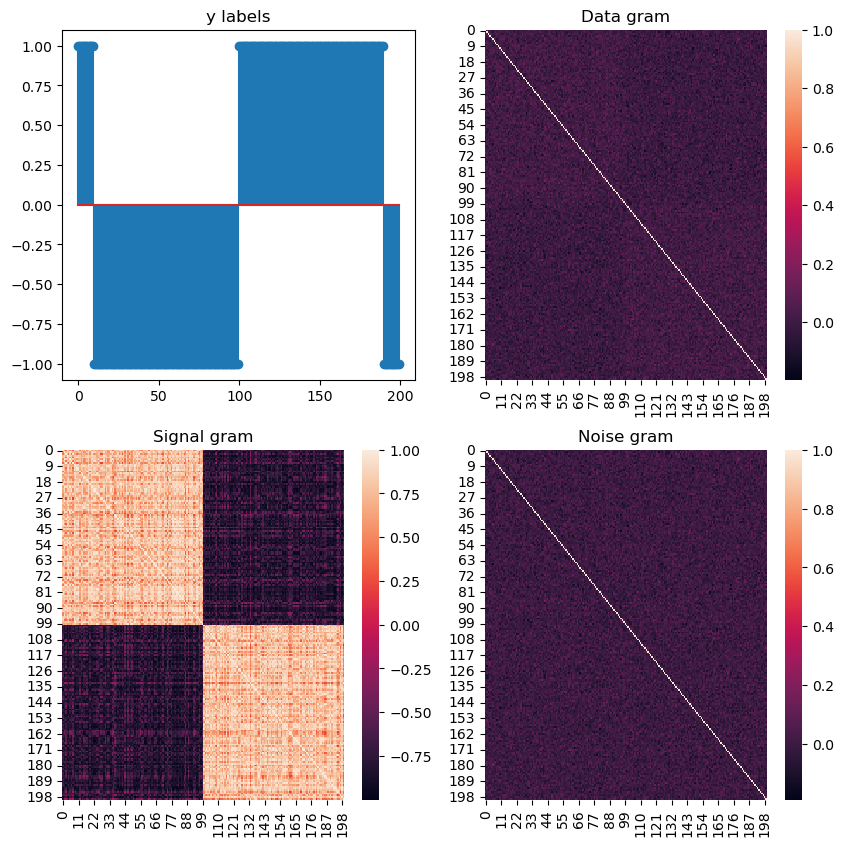

In [11]:
fig, ax = plt.subplots(2,2, figsize=(10,10))
ax[0,0].stem(range(n),y_train)
sns.heatmap(Gx, ax = ax[0,1])
sns.heatmap(Gs, ax = ax[1,0])
sns.heatmap(Gn, ax = ax[1,1])
ax[0,0].set_title("y labels")
ax[0,1].set_title("Data gram")
ax[1,0].set_title("Signal gram")
ax[1,1].set_title("Noise gram")

### Model and training

In [12]:
# !!!----- Model choices -----!!!
m = 100      # number of student neurons
bias_status = False # Note we only ever have a bias for the hidden layer
train_outer = False

In [13]:
# !!!----- Optimizater choices -----!!!
num_epochs = 1000      # Number of epochs
plot_incs = np.concatenate((np.arange(0, 10, 1), np.arange(10, 100, 10), np.arange(100, num_epochs + 1, 100))) # Points at which compute test error etc.
step_size = 1 #0.5 #0.1
batch_size = 1
a = 1 # a is the location of the elbow in the hinge loss, standard is a=1 
loss_fn = hinge_loss(1)

In [14]:
# Train in no-frills way just to check get roughly same error after similar number of updates
test_model = mod.TwoLayerNN(d, m, bias_status=bias_status, train_outer=train_outer, act='ReLU')
optimizer = torch.optim.SGD(test_model.parameters(), step_size)
test_model = train_simple(test_model, optimizer, loss_fn, X_train, y_train, int(200*num_epochs), n, batch_size)
final_train_error = (100/n)*torch.sum(torch.abs(0.5 * (torch.sign(test_model(X_train)) - y_train))).item()
final_test_error = (100/n)*torch.sum(torch.abs(0.5 * (torch.sign(test_model(X_test)) - y_test))).item()
print("Final train error: " + str(final_train_error))
print("Final test error: " + str(final_test_error))

100%|█████████████████████████████████| 200001/200001 [00:55<00:00, 3581.11it/s]

Final train error: 0.25
Final test error: 11.5


In [17]:
# !!!----- TRAIN MODEL -----!!!
model = mod.TwoLayerNN(d, m, bias_status=bias_status, train_outer=train_outer, act='ReLU')
optimizer = torch.optim.SGD(model.parameters(), step_size)
model,loss_error_curves,activations = train_detailed(model, m, optimizer, loss_fn, X_train, y_train, N_train, S_train, X_test, y_test, num_epochs, n, n, batch_size, corr_inds, clean_inds)
print("Final train error: " + str(loss_error_curves[3][-1]) + "%")
print("Final test error: " + str(loss_error_curves[7][-1]) + "%")

100%|███████████████████████████████████████| 1000/1000 [01:02<00:00, 16.13it/s]

Final train error: 0.0%
Final test error: 11.5%


#### Plot loss and error curves to inspect training

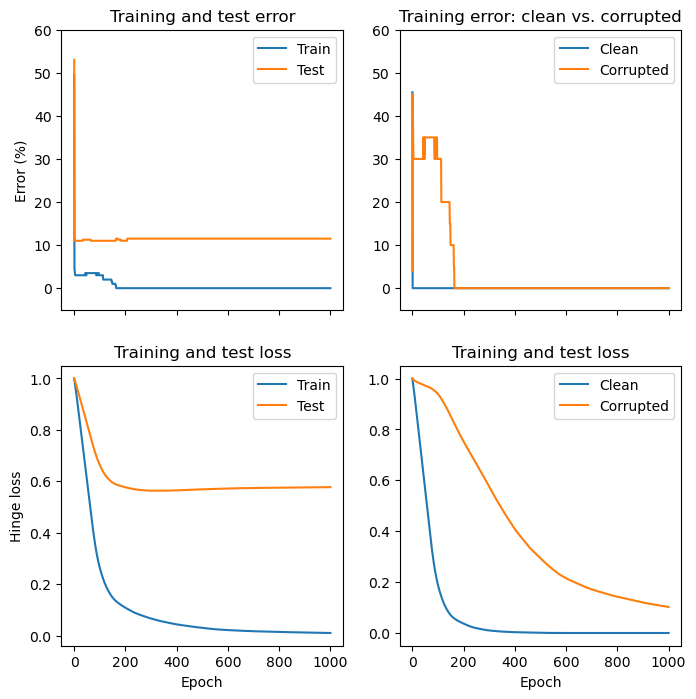

In [18]:
yub = 60
ylb = -5

# Plot the training and test error loss curves
fig, ax = plt.subplots(2,2,figsize=(8,8), sharex=True)
ax[0,0].plot(np.arange(num_epochs+1),loss_error_curves[3], label="Train")
ax[0,0].plot(np.arange(num_epochs+1),loss_error_curves[7], label="Test")
ax[0,0].set_ylabel("Error (%)")

# ax[0,0].set_xlabel("Epoch")
ax[0,0].set_title("Training and test error")
ax[0,0].set_ylim([ylb, yub])
ax[0,0].legend()

ax[0,1].plot(np.arange(num_epochs+1),loss_error_curves[4], label="Clean")
ax[0,1].plot(np.arange(num_epochs+1),loss_error_curves[5], label="Corrupted")
# ax[0,1].set_ylabel("Error (%)")
# ax[0,1].set_xlabel("Epoch")
ax[0,1].set_title("Training error: clean vs. corrupted")
ax[0,1].set_ylim([ylb, yub])
ax[0,1].legend()

ax[1,0].plot(np.arange(num_epochs+1),loss_error_curves[0], label="Train")
ax[1,0].plot(np.arange(num_epochs+1),loss_error_curves[6], label="Test")
ax[1,0].set_ylabel("Hinge loss")
ax[1,0].set_xlabel("Epoch")
ax[1,0].set_title("Training and test loss")
ax[1,0].legend()

ax[1,1].plot(np.arange(num_epochs+1),loss_error_curves[1], label="Clean")
ax[1,1].plot(np.arange(num_epochs+1),loss_error_curves[2], label="Corrupted")
ax[1,1].set_xlabel("Epoch")
ax[1,1].set_title("Training and test loss")
ax[1,1].legend()

#### Preactivations on noisy inputs

<StemContainer object of 3 artists>

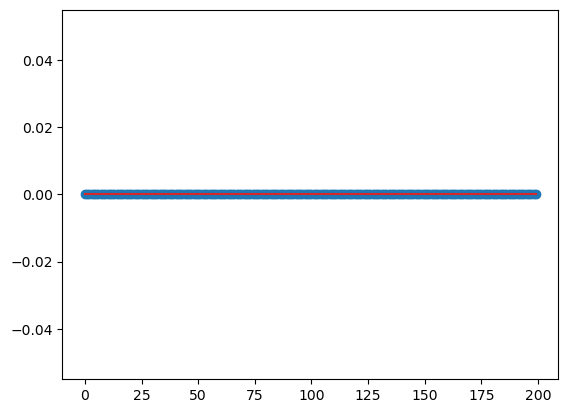

In [24]:
# Observe which points have been fitted and which ones haven't
plt.stem(range(n),np.abs(y_train.detach() - torch.sign(model(X_train)).detach().numpy()))
ax[0,0].stem(range(n),y_train)

In [49]:
preactivations = activations[0]
noise_preactivations = np.sqrt(1-gamma)*activations[1]
signal_preactivations = np.sqrt(gamma)*activations[2]

Text(0.5, 0.98, 'Preactivation of data with index 194 against neurons')

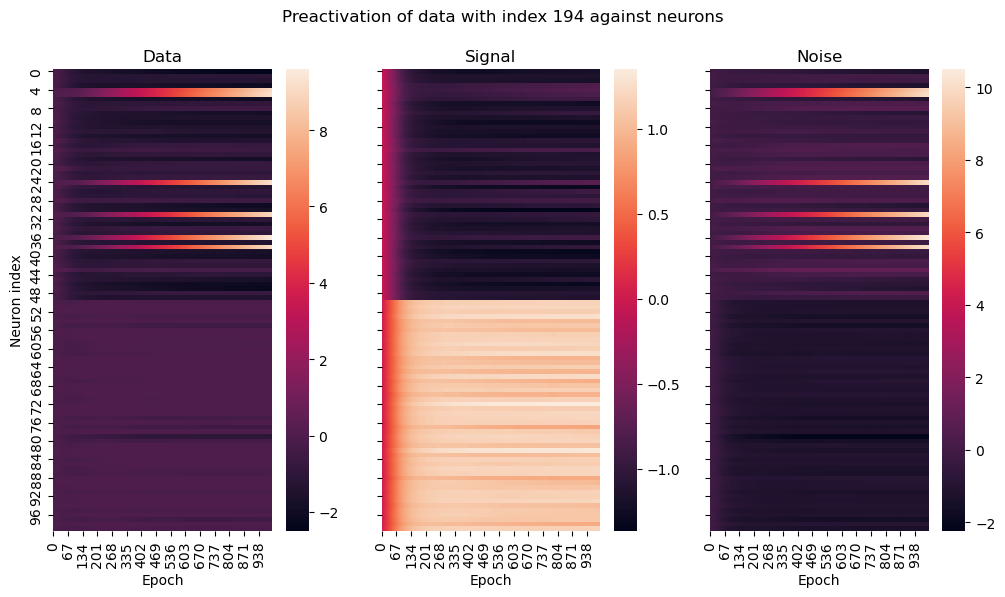

In [73]:
# data_ind = 0 #false negative
#data_ind = 20 # true negative
data_ind = 194 # false positive
# data_ind = 150 # true positive

plot_epoch = num_epochs

fig, ax = plt.subplots(1,3, figsize = (12,6), sharey = True, sharex = True)
sns.heatmap(preactivations[data_ind,:,:plot_epoch], ax = ax[0])
sns.heatmap(signal_preactivations[data_ind,:,:plot_epoch], ax = ax[1])
sns.heatmap(noise_preactivations[data_ind,:,:plot_epoch], ax = ax[2])
ax[0].set_ylabel("Neuron index")
ax[0].set_xlabel("Epoch")
ax[0].set_title("Data")
ax[1].set_xlabel("Epoch")
ax[1].set_title("Signal")
ax[2].set_xlabel("Epoch")
ax[2].set_title("Noise")
plt.suptitle("Preactivation of data with index " + str(data_ind) + " against neurons")


The above plot shows the preacativation of a data point against each neuron. For clean points we observe the following (data_ind = 20 is an example of a true negative, data_ind = 150 is an example of a true positive)
1) At the beginning the preactivation is small and close to 0.
2) After training true negative data points strongly activate neurons which match their sign: in particular neurons 0-49 have a -1 output weight and 50-99 a +1 output weight. As a result true positives activate the bottom half of neurons and true negatives activate the upper half. For small r activation size will be more homogeneous across these neuron halves, larger r leads to greater diversity.
3) Activation on a data point grows but fairly quickly saturates during training. In short the signal part is learned very quickly!
4) The signal part of a data point rapdily correlates with neurons of the same sign, the noise part of a clean data point does not seem to correlate particularly.

For corrupted data points we observe the following (data_ind = 0 is an example of a false negative, data_ind = 194 is an example of a false positive).
1) Activation is sparser (although sometimes not actually that sparse to be fair). False negatives activate typically just a few negative neurons, while false positives activate typically just a few positive neurons.
2) In terms of signal component, the signal aspect of a noisy point activates relatively minorly with neurons of the opposite sign. The noise component by contrast activates very strongly with the a few neurons of the same sign/ label.
3) Note that compared to the clean points the noisy component is learnt far slower, this is because the noise of one data point is unique (and orthogonal to all other noise and signal components), while the signal component of a point lies on the same small subspace as half the other points.
4) In addition, fitting the noise seems to be a continuous process: to be clear it seems like neurons which activate well with the noise component initially eventually fit it.
5) In addition by changing plot_epoch one can zoom in on the first few epochs and see that neurons which align with the noise sufficiently at the start (i.e., preactivation is above a threshold to be investigated) fit the noise eventually.

**Summary: the signal components of clean data points are learned by neurons of the same sign, while the noise components of corrupted data points are learned by neurons of the same sign. Noise is fitted by certain neurons with the same sign as the corruption learning the noise of component of said corrupted point.**

